In [14]:
import anndata
import scvelo as scv
import pandas as pd
import numpy as np
import matplotlib as plt
import igraph
from matplotlib import pyplot
from matplotlib.colors import ListedColormap
import scanpy as sc
import os
import re
import pickle

I'll be following the scvelo vignette for performing RNA velocity analysis BEYOND creating stream plots. Those are all contained in the velocity_analysis.qmd markdown.

I'm performing this analysis for just the objects that contain cancer cells.

In [2]:
ob_names = os.listdir("loom_output/metadata")
ob_names = list(filter(lambda x:"cancer" in x, ob_names))
ob_names = list(filter(lambda x:"dogs_mets_cancer_cells" != x, ob_names))


First, I'm going to get the top 100 genes in terms of "velocity score" within each Ann_Level3, and write these off as a table.

In [3]:
velo_gene_list = dict()
ob_list = dict()
for ob in ob_names:
    tmp = anndata.read("loom_output/anndata/" + ob + ".ad")
    ob_list[ob] = tmp
    scv.tl.rank_velocity_genes(tmp, groupby = "Ann_Level3", min_corr = 0.3)
    rank_genes = tmp.uns["rank_velocity_genes"]
    df = pd.DataFrame(tmp.uns["rank_velocity_genes"]["names"])
    velo_gene_list[ob] = df
    df.to_csv("loom_output/velocity_genes/" + ob + ".csv", index = False)



ranking velocity genes
    finished (0:00:01) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
ranking velocity genes
    finished (0:00:30) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
ranking velocity genes
    finished (0:00:01) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
ranking velocity genes
    finished (0:00:18) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
ranking velocity genes
    finished (0:00:17) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


Now I'm going to evaluate speed and confidence of velocity estimates. The speed is defined as the magnitude of the rna velocity for a cell/cluster (i.e. the rate of differentiation), and the confidence is defined as coherence of a cell's velocity vector with its neighboring cells in the umap space.

In [ ]:
for ob in ob_names:
    tmp = ob_list[ob]
    scv.tl.velocity_confidence(tmp)
    ob_list[ob] = tmp

keys = "velocity_length", "velocity_confidence"
scv.pl.scatter(ob_list["patient_prim_cancer_cells"], c = keys, perc = [5, 95], basis = "umap", cmap = "coolwarm")

In [ ]:
scv.pl.scatter(ob_list["patient_mets_cancer_cells"], c = keys, perc = [5, 95], basis = "umap", cmap = "coolwarm")

In [ ]:
scv.pl.scatter(ob_list["mm_prim_cancer_cells"], c = keys, perc = [5, 95], basis = "umap", cmap = "coolwarm")

In [ ]:
scv.pl.scatter(ob_list["mm_mets_cancer_cells"], c = keys, perc = [5, 95], basis = "umap", cmap = "coolwarm")

In [ ]:
scv.pl.scatter(ob_list["dogs_prim_cancer_cells"], c = keys, perc = [5, 95], basis = "umap", cmap = "coolwarm")

We're now going to investigate the trajectories of the rna velocity estimates, and get a more empirical figure of how the cells are differentiating according to the velocity estimates.

In [12]:
#we'll use paga to investigate the velocity trajectories
for ob in ob_names:
    tmp = ob_list[ob]
    tmp.uns['neighbors']['distances'] = tmp.obsp['distances']
    tmp.uns['neighbors']['connectivities'] = tmp.obsp['connectivities']
    scv.tl.paga(tmp, groups='Ann_Level3')
    ob_list[ob] = tmp


with open("output/python_objects/cancer_ad_list.pkl", "wb") as file:
    pickle.dump(ob_list, file)

computing terminal states
    identified 3 regions of root cells and 4 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:01) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)
computing terminal states
    identified 5 regions of root cells and 10 regions of end points .
    finished (0:02:03) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:25) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', conn

In [32]:
keys = ['velocity_length', 'velocity_confidence']
for ob in ob_names:
    tmp = ob_list[ob]
    df = tmp.obs.groupby('Ann_Level3')[keys].mean().T
    df.style.background_gradient(cmap='coolwarm', axis=1)



In [27]:
df = scv.get_df(tmp, 'paga/transitions_confidence', precision=2).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')

,0,1,2,3,4,5
0,0,0,0,0,0,0
1,0,0,0,0.23,0,0
2,0,0.09,0,0,0.045,0
3,0.15,0,0,0,0,0.16
4,0,0,0,0,0,0
5,0,0,0,0,0,0


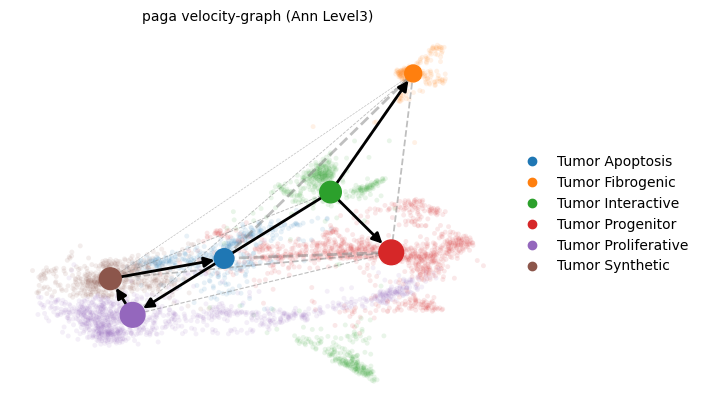

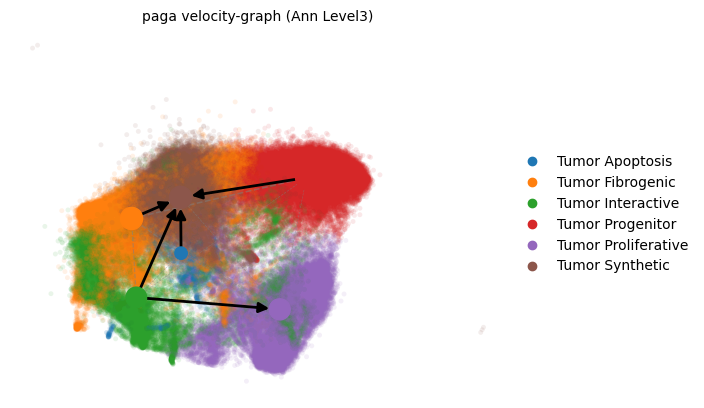

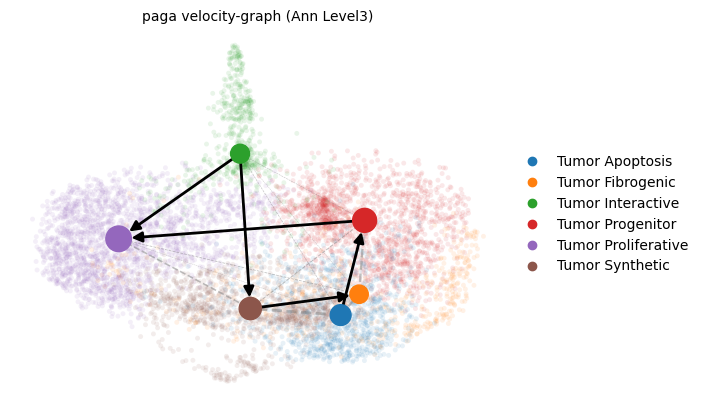

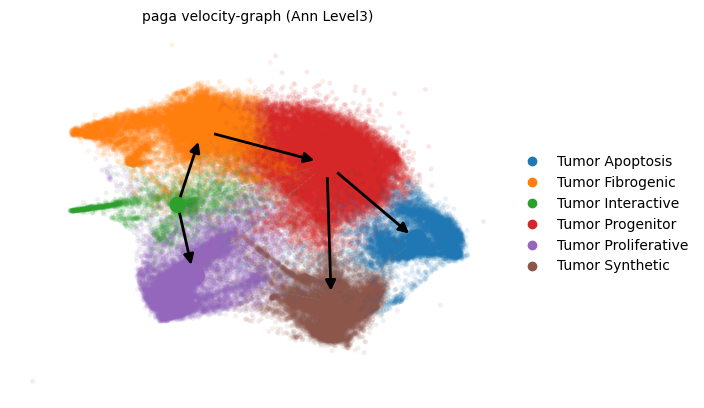

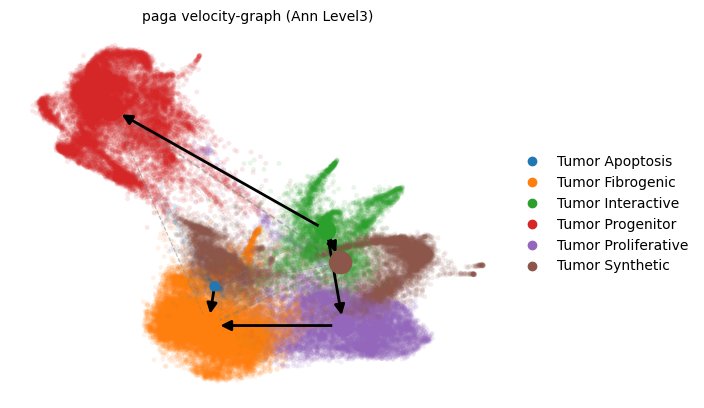

In [29]:
for ob in ob_names:
    tmp = ob_list[ob]
    scv.pl.paga(tmp, basis='fdl', size=50, alpha=.1,
                min_edge_width=2, node_size_scale=1.5)